# Esercitazione 7

Nella cartella sono presenti il notebook ed i dati di output (per l'autocorrelazione e per il confronto MD vs MC).

<img src="Menu.png">

Nella cartella __MD_MC/MDNVE_MCNVT__ sono presenti:
- Vari file di input ed output.
- Il codice sorgente (in comune con l'esercitazione 4).
- Il makefile.

<img src="Menu1.png">

Librerie necessarie per il notebook.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

## 1 Simulazione Monte Carlo

Un altro modo per svolgere l'esercitazione 4 può essere quello di usare un campionamento stocastico al posto della dinamica molecolare, perciò utilizzare l'*algoritmo di Metropolis* a posto di quello di *Varlet*.

### 1.1 Correzioni di Coda

Per prima cosa miglioriamo il codice.  Dopo il *raggio di cut-off* $r_c$ abbiamo assunto che il potenziale abbia un effetto trascurabile, ma non è così.  L'interazione tra particalle lontane è piccolo ma non strascurabile, perciò aggiungiamo quelle che vengono chiamate __correzioni di coda__.

Visto che le particelle sono lontane si comportano praticamente come un gas ideale e visto che il valore è minimo possiamo dire che:
$$
\left \langle V_{LJ} \right \rangle _{tail}=8\,\pi\,\rho_{LJ}\,\varepsilon\left[\frac{1}{9}\,\frac{1}{r_{c(LJ)}^9} - \frac{1}{3}\,\frac{1}{r_{c(LJ)}^3}\right]
$$
dove $r_{c(LJ)}=\frac{r_c}{\sigma}$ .

Ricordandoci la formula della pressione in funzione del *viriale*:
$$
P=\rho\,k_b\,T-\frac{\langle W\rangle}{N}
$$

Possiamo ricaverci le correzioni anche per la pressione da:
$$
\frac{\langle W_{LJ} \rangle _{tail}}{3\,N\,\varepsilon}=32\,\rho_{LJ}\left[\frac{1}{9}\,\frac{1}{r^9_{c(LJ)}} - \frac{1}{6}\,\frac{1}{r^3_{c(LJ)}}\right]
$$

### 1.2  Tempo di Autocorrelazione

Il tempo di correlazione è il tempo che ci mette il sistema ad andare da uno stato ad un altro significativamente diverso dal primo.  L'autocorrelazione di un osservabile $f(t)$, si calcola:
$$
\chi(t)=\frac{\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}f(t')\,f(t'+t)-\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}f(t')\,\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}f(t'+t)}{\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}f^2(t')-\left(\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}f(t')\right)^2}
$$

La scelta della dimensione dei blocchi dipende dal tempo di correlazione.

Per studiarla utiliziamo simulazioni con $M=5\cdot10^5$ step, per ciascuna fase.

#### 1.2.1 Funzione di Autocorrelazione

Studiamo la funzione di autocorrelazione $\chi(t)$ per le diverse fasi.

- Fase Solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- Fase Liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- Fase Gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Osserviamo per i dati simulati l'autocorrelazione di *energia potenziale* e *pressione*.

In [2]:
#Fase Solida
solid_epot=np.loadtxt("Autocorrelation/solid_epot.dat")
solid_pres=np.loadtxt("Autocorrelation/solid_pres.dat")
#Fase Liquida
liquid_epot=np.loadtxt("Autocorrelation/liquid_epot.dat")
liquid_pres=np.loadtxt("Autocorrelation/liquid_pres.dat")
#Fase Gassosa
gas_epot=np.loadtxt("Autocorrelation/gas_epot.dat")
gas_pres=np.loadtxt("Autocorrelation/gas_pres.dat")

In [3]:
tmax=np.shape(solid_epot)[0]
nval=1000

v=[]

def set_chi(in_v):
    v=in_v
    c=1./tmax*np.sum(v**2)
    d=(1./tmax*np.sum(v))**2

def autocorr(t):
    a=1./(tmax-t)*np.sum(v[:int(tmax-t)]*v[int(t):])
    b=1./(tmax-t)*np.sum(v[:int(tmax-t)])*1./(tmax-t)*np.sum(v[int(t):])

    return ((a-b)/(c-d))


__Fase Solida__

In [4]:
epot=np.zeros(nval)
pres=np.zeros(nval)

v=solid_epot[:,1]
w=solid_pres[:,1]

c1=1./tmax*np.sum(v**2)
c2=1./tmax*np.sum(w**2)

d1=(1./tmax*np.sum(v))**2
d2=(1./tmax*np.sum(w))**2

for i in range(nval):
    t=i+1

    a1=1./(tmax-t)*np.sum(v[:int(tmax-t)]*v[int(t):])
    a2=1./(tmax-t)*np.sum(w[:int(tmax-t)]*w[int(t):])

    b1=1./(tmax-t)*np.sum(v[:int(tmax-t)])*1./(tmax-t)*np.sum(v[int(t):])
    b2=1./(tmax-t)*np.sum(w[:int(tmax-t)])*1./(tmax-t)*np.sum(w[int(t):])

    epot[i]=((a1-b1)/(c1-d1))
    pres[i]=((a2-b2)/(c2-d2))

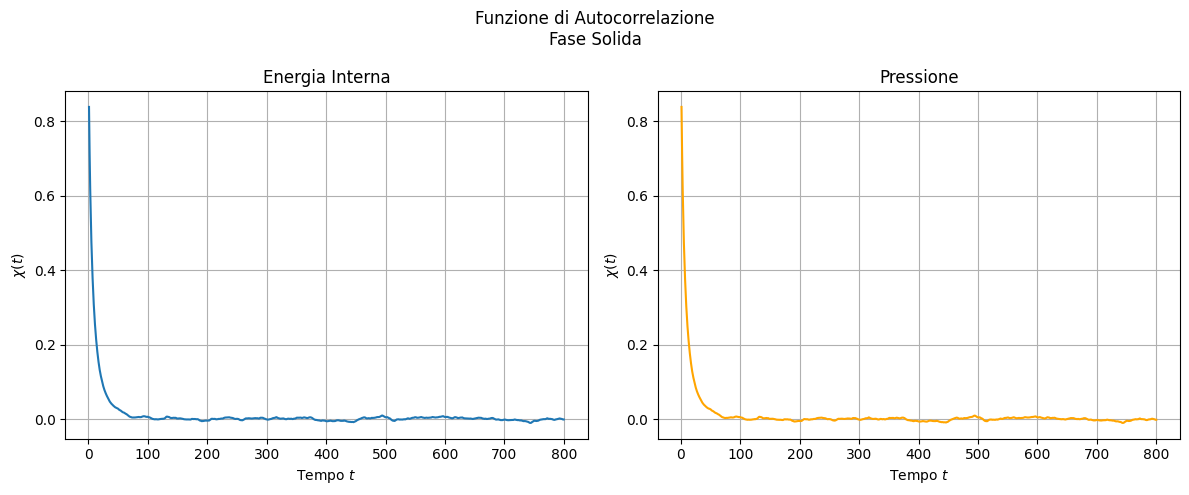

In [5]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
nval=800
x=np.linspace(1,nval,nval)

ax[0].plot(x,epot[:nval])
ax[1].plot(x,pres[:nval],color='orange')

ax[0].set_title("Energia Interna")
ax[1].set_title("Pressione")

for axx in ax:
    axx.set(xlabel=r"Tempo $t$",ylabel=r"$\chi(t)$")
    axx.grid(True)

fig.suptitle(f"Funzione di Autocorrelazione\nFase Solida")

plt.tight_layout()
plt.show()

Possiamo osservare che l'autocorrelazione va a zero per entrambe le osservabili intorno a $100$ perciò possiamo scegliere come dimensione dei blocchi da $100$ in poi.

__Fase Liquida__

In [6]:
nval=1000
epot=np.zeros(nval)
pres=np.zeros(nval)

v=liquid_epot[:,1]
w=liquid_pres[:,1]

c1=1./tmax*np.sum(v**2)
c2=1./tmax*np.sum(w**2)

d1=(1./tmax*np.sum(v))**2
d2=(1./tmax*np.sum(w))**2

for i in range(nval):
    t=i+1

    a1=1./(tmax-t)*np.sum(v[:int(tmax-t)]*v[int(t):])
    a2=1./(tmax-t)*np.sum(w[:int(tmax-t)]*w[int(t):])

    b1=1./(tmax-t)*np.sum(v[:int(tmax-t)])*1./(tmax-t)*np.sum(v[int(t):])
    b2=1./(tmax-t)*np.sum(w[:int(tmax-t)])*1./(tmax-t)*np.sum(w[int(t):])

    epot[i]=((a1-b1)/(c1-d1))
    pres[i]=((a2-b2)/(c2-d2))

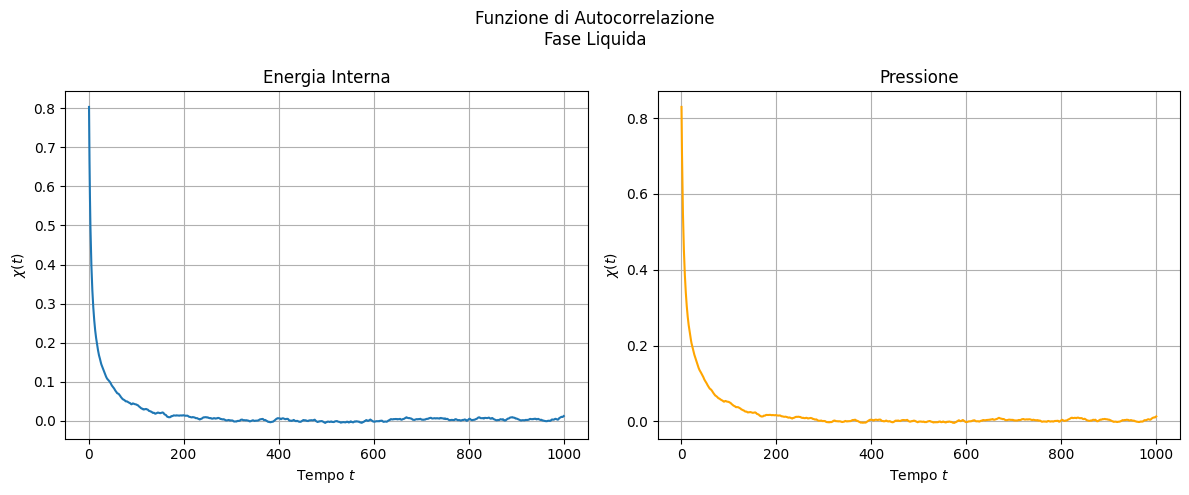

In [7]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
x=np.linspace(1,nval,nval)

ax[0].plot(x,epot)
ax[1].plot(x,pres,color='orange')

ax[0].set_title("Energia Interna")
ax[1].set_title("Pressione")

for axx in ax:
    axx.set(xlabel=r"Tempo $t$",ylabel=r"$\chi(t)$")
    axx.grid(True)

fig.suptitle(f"Funzione di Autocorrelazione\nFase Liquida")

plt.tight_layout()
plt.show()

Osserviamo che l'autocorrelazione decresce più lentamente che nel caso precedente.  Vediamo che $\chi(t)$ diventa trascurabile intorno a $200$ quindi possiamo schegliere la diensione dei blocchi da $200$ in poi.

__Fase Gassosa__

In [8]:
nval=100
epot=np.zeros(nval)
pres=np.zeros(nval)

v=gas_epot[:,1]
w=gas_pres[:,1]

c1=1./tmax*np.sum(v**2)
c2=1./tmax*np.sum(w**2)

d1=(1./tmax*np.sum(v))**2
d2=(1./tmax*np.sum(w))**2

for i in range(nval):
    t=i+1

    a1=1./(tmax-t)*np.sum(v[:int(tmax-t)]*v[int(t):])
    a2=1./(tmax-t)*np.sum(w[:int(tmax-t)]*w[int(t):])

    b1=1./(tmax-t)*np.sum(v[:int(tmax-t)])*1./(tmax-t)*np.sum(v[int(t):])
    b2=1./(tmax-t)*np.sum(w[:int(tmax-t)])*1./(tmax-t)*np.sum(w[int(t):])

    epot[i]=((a1-b1)/(c1-d1))
    pres[i]=((a2-b2)/(c2-d2))

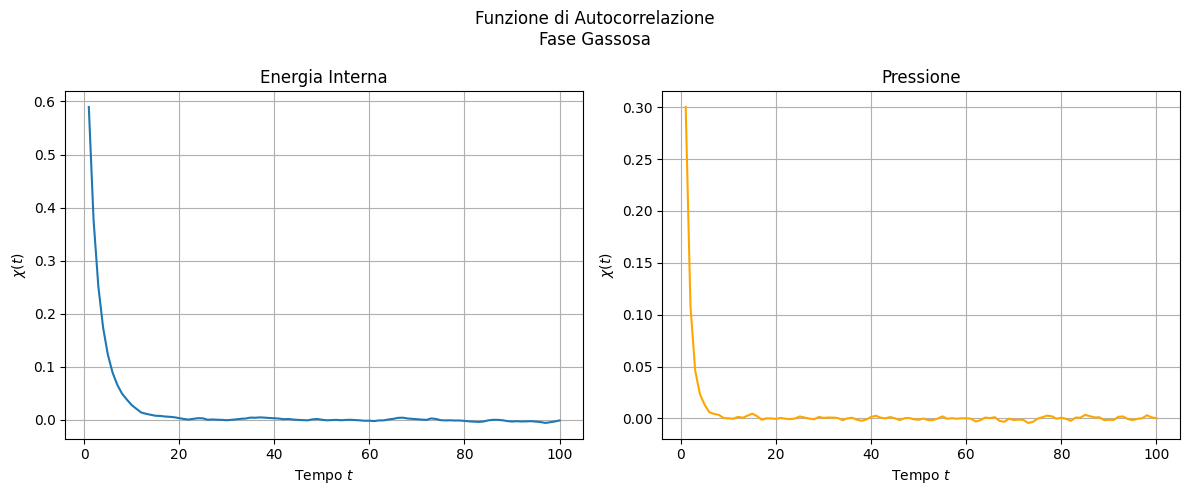

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
x=np.linspace(1,nval,nval)

ax[0].plot(x,epot)
ax[1].plot(x,pres,color='orange')

ax[0].set_title("Energia Interna")
ax[1].set_title("Pressione")

for axx in ax:
    axx.set(xlabel=r"Tempo $t$",ylabel=r"$\chi(t)$")
    axx.grid(True)

fig.suptitle(f"Funzione di Autocorrelazione\nFase Gassosa")

plt.tight_layout()
plt.show()

Possiamo vedere che in questo caso l'autocorrelazione per l'energia diventa trscurabile vicino a $20$ step e per la presione si stabilizza intorno allo stesso valore questo vuol dire che come dimensione prenderemo $30$ step.

#### 1.2.2 Errore in Funzione della Dimensione dei Blocchi

Osserviamo come varia l'errore variando il numero di step per blocco.

__Fase Solida__

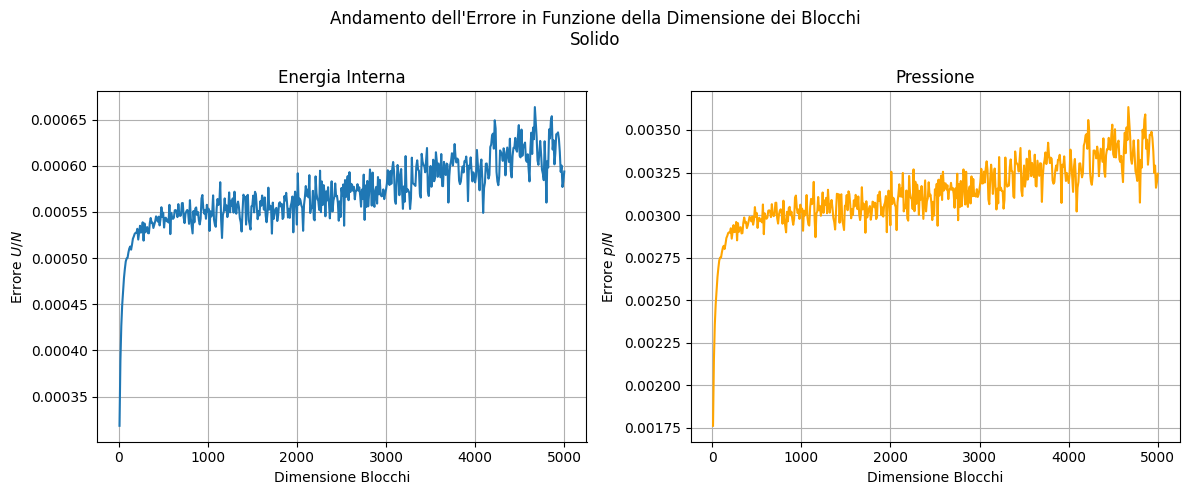

In [10]:
#Creo un array con i valori delle dimansioni dei blocchi
L=np.arange(10,5001,10)

#Calcolo gli errori
blk_ave_epot=np.array([])
err_epot=np.array([])

blk_ave_pres=np.array([])
err_pres=np.array([])

M=np.shape(solid_epot)[0]

for l in L:
    N=int(M/l)
    blk_ave_epot=np.zeros(N)
    blk_ave_pres=np.zeros(N)
    for i in range(int(N)):
        blk_ave_epot[i]=np.average(solid_epot[i*l:(i+1)*l,1])
        blk_ave_pres[i]=np.average(solid_pres[i*l:(i+1)*l,1])
    
    ave_epot=np.average(blk_ave_epot)
    ave2_epot=np.average(blk_ave_epot**2)

    ave_pres=np.average(blk_ave_pres)
    ave2_pres=np.average(blk_ave_pres**2)

    err_epot=np.append(err_epot,np.sqrt((ave2_epot-ave_epot**2)/(N-1)))
    err_pres=np.append(err_pres,np.sqrt((ave2_pres-ave_pres**2)/(N-1)))

#Faccio il grafico
fig, ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(L,err_epot)
ax[0].set(ylabel=r"Errore $U/N$")
ax[0].set_title("Energia Interna")

ax[1].plot(L,err_pres,color="orange")
ax[1].set(ylabel=r"Errore $p/N$")
ax[1].set_title("Pressione")

for i in range(2):
    ax[i].grid(True)
    ax[i].set(xlabel=("Dimensione Blocchi"))

fig.suptitle(f"Andamento dell'Errore in Funzione della Dimensione dei Blocchi\nSolido")
plt.tight_layout()
plt.show()
    

Notiamo che aumentando la dimensione dei blocchi l'errore inizialmente aumenta per poi stabilizzarsi.  Questo è dovuto all'autocorrelazione: i primi valori dove l'autocorrelazoine è significativa i valori sono maggiormente influenzati dalla relazione tra loro.  Infine quando l'autocorrelazione è trascurabile possiamo vedere un errore costante.  Le oscillazioni sono dovute al fatto che aumentando la dimansione dei blocchi il numero dei blocchi diminuisce, visto che il nummero di dati resta costante.

__Fase Liquida__

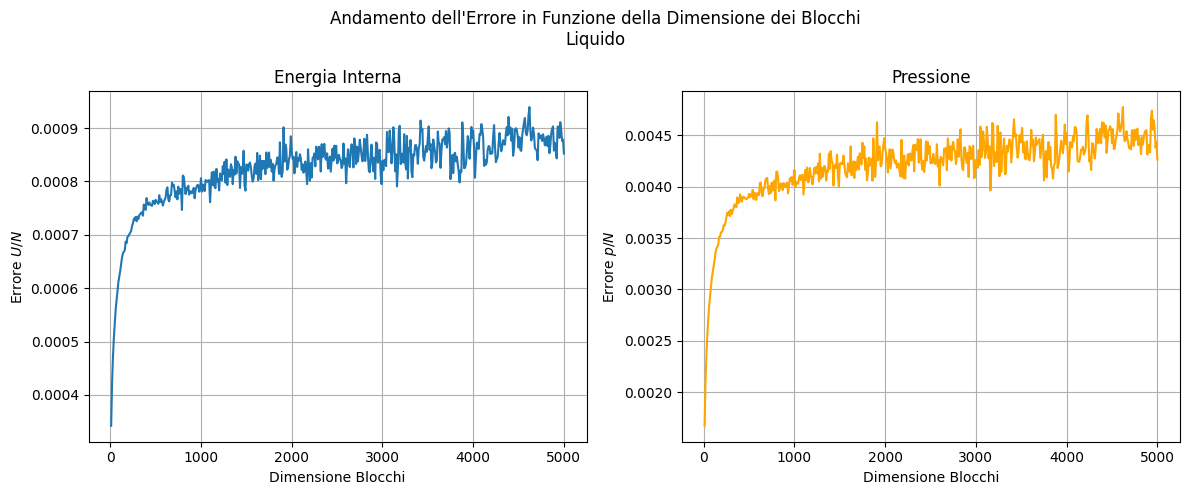

In [11]:
#Creo un array con i valori delle dimansioni dei blocchi
L=np.arange(10,5001,10)

#Calcolo gli errori
blk_ave_epot=np.array([])
err_epot=np.array([])

blk_ave_pres=np.array([])
err_pres=np.array([])

M=np.shape(liquid_epot)[0]

for l in L:
    N=int(M/l)
    blk_ave_epot=np.zeros(N)
    blk_ave_pres=np.zeros(N)
    for i in range(int(N)):
        blk_ave_epot[i]=np.average(liquid_epot[i*l:(i+1)*l,1])
        blk_ave_pres[i]=np.average(liquid_pres[i*l:(i+1)*l,1])
    
    ave_epot=np.average(blk_ave_epot)
    ave2_epot=np.average(blk_ave_epot**2)

    ave_pres=np.average(blk_ave_pres)
    ave2_pres=np.average(blk_ave_pres**2)

    err_epot=np.append(err_epot,np.sqrt((ave2_epot-ave_epot**2)/(N-1)))
    err_pres=np.append(err_pres,np.sqrt((ave2_pres-ave_pres**2)/(N-1)))

#Faccio il grafico
fig, ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(L,err_epot)
ax[0].set(ylabel=r"Errore $U/N$")
ax[0].set_title("Energia Interna")

ax[1].plot(L,err_pres,color="orange")
ax[1].set(ylabel=r"Errore $p/N$")
ax[1].set_title("Pressione")

for i in range(2):
    ax[i].grid(True)
    ax[i].set(xlabel=("Dimensione Blocchi"))

fig.suptitle(f"Andamento dell'Errore in Funzione della Dimensione dei Blocchi\nLiquido")
plt.tight_layout()
plt.show()
    

Anche in questo caso notiamo che l'errore inizia ad oscillare intorno ad un valore costante quando la dimensione dei blocchi supera un certo valore.

__Fase Gassosa__

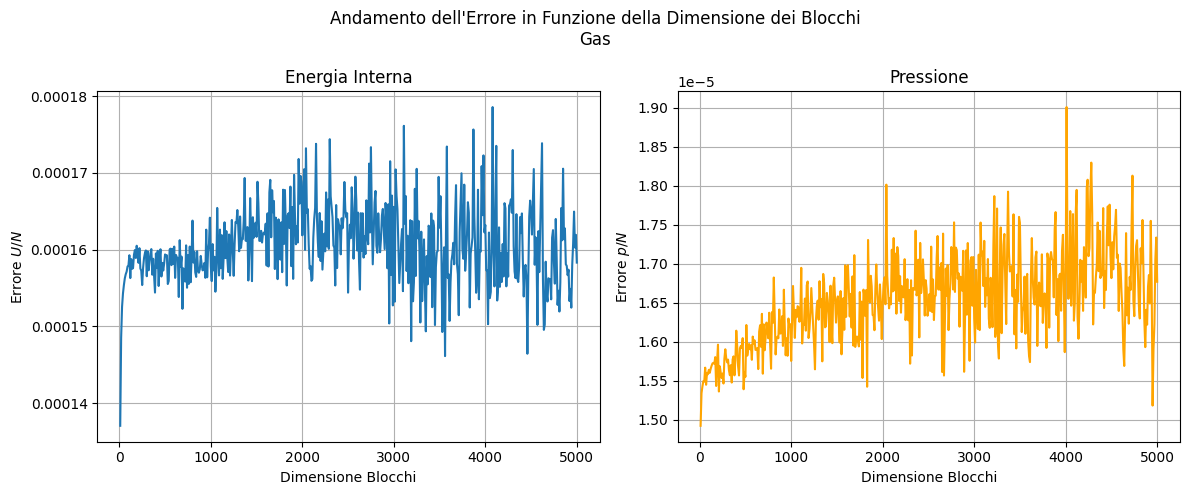

In [12]:
#Creo un array con i valori delle dimansioni dei blocchi
L=np.arange(10,5001,10)

#Calcolo gli errori
blk_ave_epot=np.array([])
err_epot=np.array([])

blk_ave_pres=np.array([])
err_pres=np.array([])

M=np.shape(gas_epot)[0]

for l in L:
    N=int(M/l)
    blk_ave_epot=np.zeros(N)
    blk_ave_pres=np.zeros(N)
    for i in range(int(N)):
        blk_ave_epot[i]=np.average(gas_epot[i*l:(i+1)*l,1])
        blk_ave_pres[i]=np.average(gas_pres[i*l:(i+1)*l,1])
    
    ave_epot=np.average(blk_ave_epot)
    ave2_epot=np.average(blk_ave_epot**2)

    ave_pres=np.average(blk_ave_pres)
    ave2_pres=np.average(blk_ave_pres**2)

    err_epot=np.append(err_epot,np.sqrt((ave2_epot-ave_epot**2)/(N-1)))
    err_pres=np.append(err_pres,np.sqrt((ave2_pres-ave_pres**2)/(N-1)))

#Faccio il grafico
fig, ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(L,err_epot)
ax[0].set(ylabel=r"Errore $U/N$")
ax[0].set_title("Energia Interna")

ax[1].plot(L,err_pres,color="orange")
ax[1].set(ylabel=r"Errore $p/N$")
ax[1].set_title("Pressione")

for i in range(2):
    ax[i].grid(True)
    ax[i].set(xlabel=("Dimensione Blocchi"))

fig.suptitle(f"Andamento dell'Errore in Funzione della Dimensione dei Blocchi\nGas")
plt.tight_layout()
plt.show()
    

Anche questo caso è analogo ai precedenti.

### 1.3 Funzione di Distribuzione Radiale e Paragone MD vs MC

La __funzione di dirtibuzione radiale__ descrive la probabilità di trovare due particella alla distanza $r$.  La formula per calcolarla numericamente è:
$$
g(r)=\frac{1}{\rho\,N\,\Delta V(r)} \left\langle \sum_{i=1}^N \sum_{j\neq i}\delta \left( \left|\vec{r}\right| - \left|\vec{r}_i-\vec{r}_j \right| \right)\right\rangle
$$

Adesso calcoliamo le tre grandezze per le varie fasi e paragoniamo il __Molecular Dynamics__ al __Monte Carlo__.

I sistemi che studieremo saranno:

- Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

In [13]:
solid_grad=[np.loadtxt("MD/Solid/output_grad.dat"),np.loadtxt("MC/Solid/output_grad.dat")]
liquid_grad=[np.loadtxt("MD/Liquid/output_grad.dat"),np.loadtxt("MC/Liquid/output_grad.dat")]
gas_grad=[np.loadtxt("MD/Gas/output_grad.dat"),np.loadtxt("MC/Gas/output_grad.dat")]

solid_epot=[np.loadtxt("MD/Solid/output_epot.dat"),np.loadtxt("MC/Solid/output_epot.dat")]
liquid_epot=[np.loadtxt("MD/Liquid/output_epot.dat"),np.loadtxt("MC/Liquid/output_epot.dat")]
gas_epot=[np.loadtxt("MD/Gas/output_epot.dat"),np.loadtxt("MC/Gas/output_epot.dat")]

solid_pres=[np.loadtxt("MD/Solid/output_pres.dat"),np.loadtxt("MC/Solid/output_pres.dat")]
liquid_pres=[np.loadtxt("MD/Liquid/output_pres.dat"),np.loadtxt("MC/Liquid/output_pres.dat")]
gas_pres=[np.loadtxt("MD/Gas/output_pres.dat"),np.loadtxt("MC/Gas/output_pres.dat")]

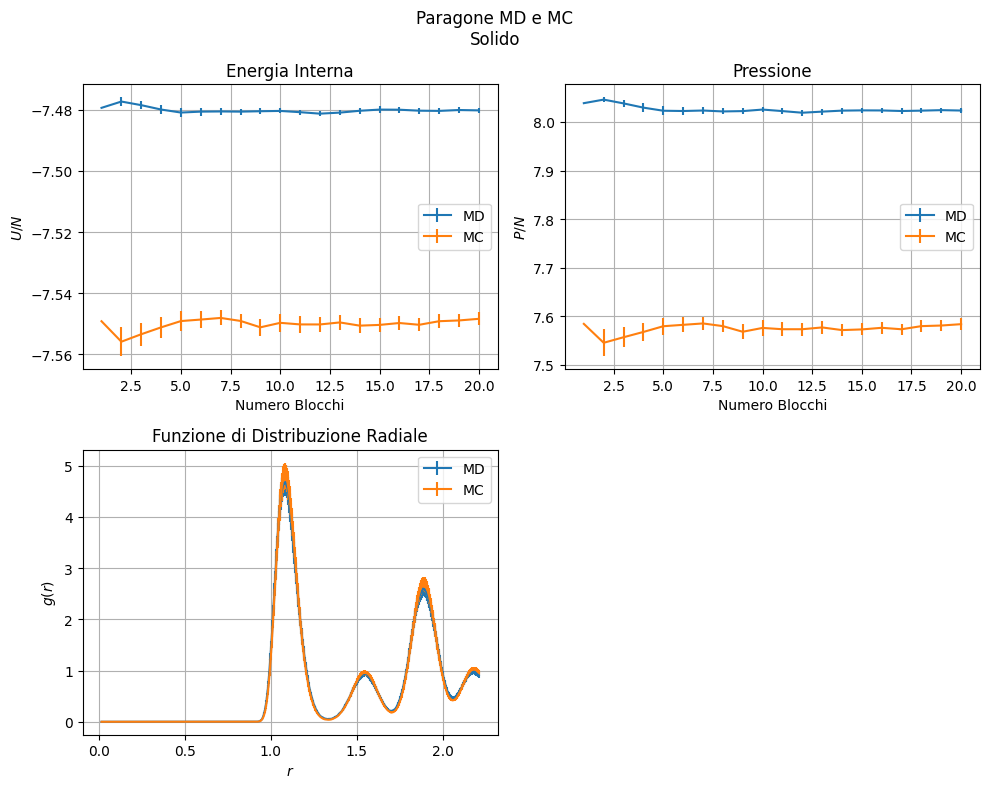

In [14]:
fig, ax=plt.subplots(2,2,figsize=(10,8))
ax=np.reshape(ax,4)

ax[0].errorbar(solid_epot[0][:,0],solid_epot[0][:,2],yerr=solid_epot[0][:,3],label="MD")
ax[0].errorbar(solid_epot[1][:,0],solid_epot[1][:,2],yerr=solid_epot[1][:,3],label="MC")
ax[0].set(
    xlabel="Numero Blocchi",
    ylabel=r"$U/N$"
)
ax[0].set_title("Energia Interna")

ax[1].errorbar(solid_pres[0][:,0],solid_pres[0][:,2],yerr=solid_pres[0][:,3],label="MD")
ax[1].errorbar(solid_pres[1][:,0],solid_pres[1][:,2],yerr=solid_pres[1][:,3],label="MC")
ax[1].set(
    xlabel="Numero Blocchi",
    ylabel=r"$P/N$"
)
ax[1].set_title("Pressione")

ax[2].errorbar(solid_grad[0][:,0],solid_grad[0][:,1],yerr=solid_grad[0][:,2],label="MD")
ax[2].errorbar(solid_grad[1][:,0],solid_grad[1][:,1],yerr=solid_grad[1][:,2],label="MC")
ax[2].set(
    xlabel=r"$r$",
    ylabel=r"$g(r)$"
)
ax[2].set_title("Funzione di Distribuzione Radiale")

for i in range(3):
    ax[i].grid(True)
    ax[i].legend()

ax[-1].axis('off')

fig.suptitle(f"Paragone MD e MC\nSolido")

plt.tight_layout()
plt.show()

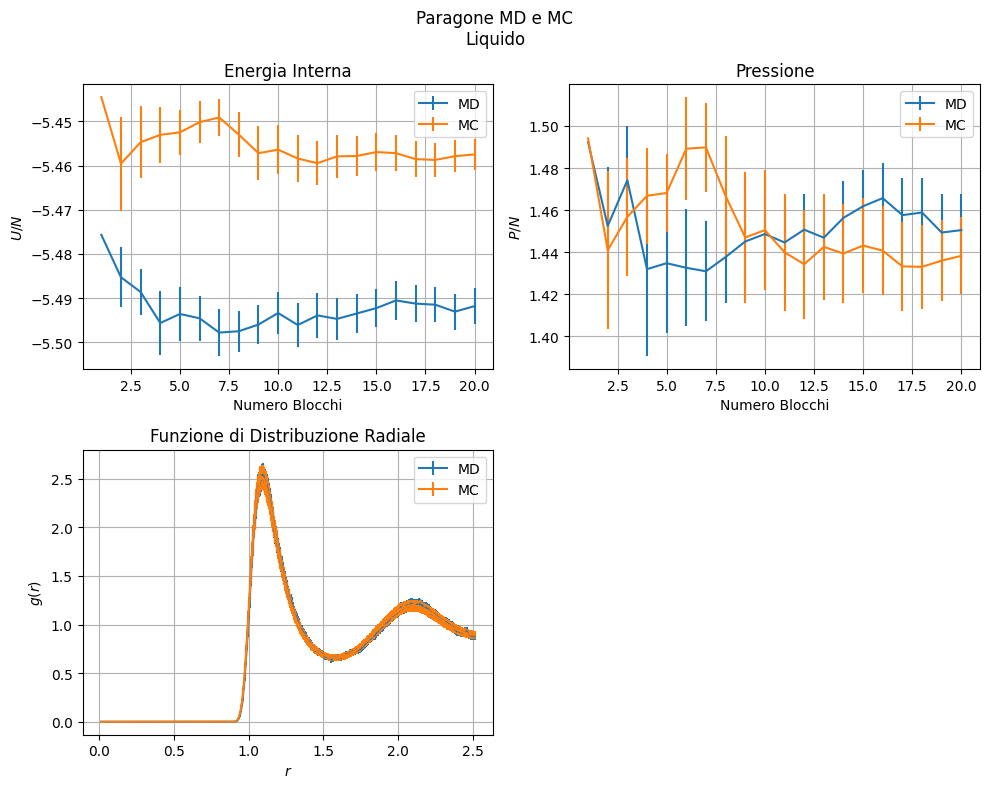

In [15]:
fig, ax=plt.subplots(2,2,figsize=(10,8))
ax=np.reshape(ax,4)

ax[0].errorbar(liquid_epot[0][:,0],liquid_epot[0][:,2],yerr=liquid_epot[0][:,3],label="MD")
ax[0].errorbar(liquid_epot[1][:,0],liquid_epot[1][:,2],yerr=liquid_epot[1][:,3],label="MC")
ax[0].set(
    xlabel="Numero Blocchi",
    ylabel=r"$U/N$"
)
ax[0].set_title("Energia Interna")

ax[1].errorbar(liquid_pres[0][:,0],liquid_pres[0][:,2],yerr=liquid_pres[0][:,3],label="MD")
ax[1].errorbar(liquid_pres[1][:,0],liquid_pres[1][:,2],yerr=liquid_pres[1][:,3],label="MC")
ax[1].set(
    xlabel="Numero Blocchi",
    ylabel=r"$P/N$"
)
ax[1].set_title("Pressione")

ax[2].errorbar(liquid_grad[0][:,0],liquid_grad[0][:,1],yerr=liquid_grad[0][:,2],label="MD")
ax[2].errorbar(liquid_grad[1][:,0],liquid_grad[1][:,1],yerr=liquid_grad[1][:,2],label="MC")
ax[2].set(
    xlabel=r"$r$",
    ylabel=r"$g(r)$"
)
ax[2].set_title("Funzione di Distribuzione Radiale")

for i in range(3):
    ax[i].grid(True)
    ax[i].legend()

ax[-1].axis('off')

fig.suptitle(f"Paragone MD e MC\nLiquido")

plt.tight_layout()
plt.show()

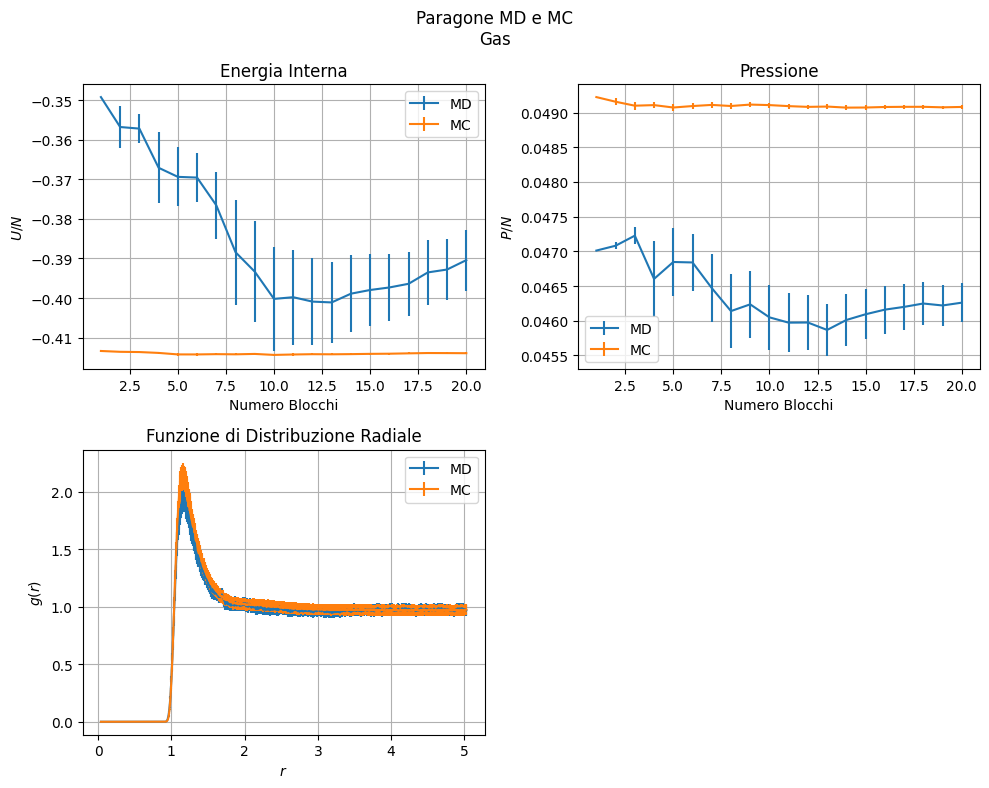

In [16]:
fig, ax=plt.subplots(2,2,figsize=(10,8))
ax=np.reshape(ax,4)

ax[0].errorbar(gas_epot[0][:,0],gas_epot[0][:,2],yerr=gas_epot[0][:,3],label="MD")
ax[0].errorbar(gas_epot[1][:,0],gas_epot[1][:,2],yerr=gas_epot[1][:,3],label="MC")
ax[0].set(
    xlabel="Numero Blocchi",
    ylabel=r"$U/N$"
)
ax[0].set_title("Energia Interna")

ax[1].errorbar(gas_pres[0][:,0],gas_pres[0][:,2],yerr=gas_pres[0][:,3],label="MD")
ax[1].errorbar(gas_pres[1][:,0],gas_pres[1][:,2],yerr=gas_pres[1][:,3],label="MC")
ax[1].set(
    xlabel="Numero Blocchi",
    ylabel=r"$P/N$"
)
ax[1].set_title("Pressione")

ax[2].errorbar(gas_grad[0][:,0],gas_grad[0][:,1],yerr=gas_grad[0][:,2],label="MD")
ax[2].errorbar(gas_grad[1][:,0],gas_grad[1][:,1],yerr=gas_grad[1][:,2],label="MC")
ax[2].set(
    xlabel=r"$r$",
    ylabel=r"$g(r)$"
)
ax[2].set_title("Funzione di Distribuzione Radiale")

for i in range(3):
    ax[i].grid(True)
    ax[i].legend()

ax[-1].axis('off')

fig.suptitle(f"Paragone MD e MC\nGas")

plt.tight_layout()
plt.show()

Osserviamo che seppur i risultati, nella maggiorparte dei casi, non siano compatibili sono simili.  Questo effetto è dovuto al fatto che il numero di particelle non sono nel limite termodinamico ($N\to+\infty$) quindi la meccanica statistica non riesce a descrivrmi al megglio quello che succede, inoltre il molecular dinamics ha una temperatura che varia e non è precisamente quella che vorremmo studiare.